In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Charger les données
file_path = 'dataset_modele_ia_2021.csv'
data = pd.read_csv(file_path)

In [3]:
# Nettoyage des données
cols_to_convert = ['Cambriolages de logement', 'Trafic de stupéfiants', 'Vols avec armes']
for col in cols_to_convert:
    data[col] = data[col].str.replace(',', '.').astype(float)

In [4]:
# Calcul du nombre de lignes nécessaires pour chaque classe
total_samples = len(data)
target_samples_class_1 = int(0.6 * total_samples)
target_samples_class_2 = total_samples - target_samples_class_1

# Échantillonnage de la classe 1 pour atteindre 60% du total
candidat_1_data = data[data['Candidat_Max_Voix_T1_2022_Encoded'] == 1]
candidat_2_data = data[data['Candidat_Max_Voix_T1_2022_Encoded'] == 2]
candidat_0_data = data[data['Candidat_Max_Voix_T1_2022_Encoded'] == 0]

# Sous-échantillonnage pour avoir exactement 60% de candidat 1
if len(candidat_1_data) > target_samples_class_1:
    candidat_1_data = candidat_1_data.sample(target_samples_class_1, random_state=42)
else:
    duplication_factor = (target_samples_class_1 // len(candidat_1_data)) - 1
    candidat_1_data = pd.concat([candidat_1_data] * duplication_factor, axis=0).sample(target_samples_class_1, random_state=42)

# Combinaison des données de classe 1 et des autres classes
balanced_data = pd.concat([candidat_1_data, candidat_2_data, candidat_0_data], axis=0).reset_index(drop=True)

# Recalculer les features et la cible avec les données équilibrées
X_balanced = balanced_data.drop(columns=['Libelle_Commune', 'Code_Commune', 'Candidat_Max_Voix_T1_2022_Encoded', 'Nombre_Voix_Max_T1_2022'])
y_balanced = balanced_data['Candidat_Max_Voix_T1_2022_Encoded']


In [5]:
# Standardisation des données
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Division des données en ensembles d'entraînement et de test
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Construction du modèle de réseau de neurones
model_nn = Sequential([
    Dense(64, input_dim=X_train_balanced.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes de sortie
])

# Compilation du modèle
model_nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history = model_nn.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=8, validation_split=0.2, verbose=0)

# Prédiction et évaluation
y_pred_balanced = model_nn.predict(X_test_balanced)
y_pred_balanced = y_pred_balanced.argmax(axis=1)
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
report_balanced = classification_report(y_test_balanced, y_pred_balanced)

print(f'Accuracy: {accuracy_balanced:.2f}')
print('Classification Report:')
print(report_balanced)

2/2 [==============================] - 0s 2ms/step
Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.80      0.89      0.84        27
           2       0.00      0.00      0.00         1

    accuracy                           0.74        35
   macro avg       0.40      0.39      0.39        35
weighted avg       0.70      0.74      0.72        35



C:\Users\felix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334

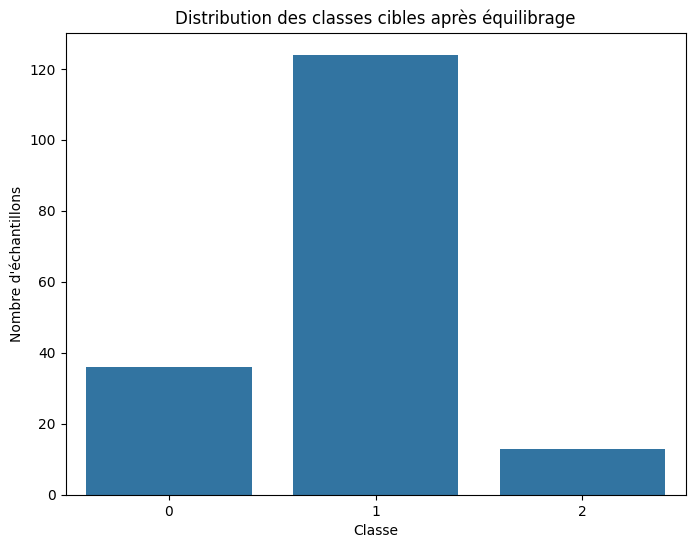

In [6]:
# 1. Distribution des classes cibles après équilibrage
plt.figure(figsize=(8, 6))
sns.countplot(x=y_balanced)
plt.title('Distribution des classes cibles après équilibrage')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()


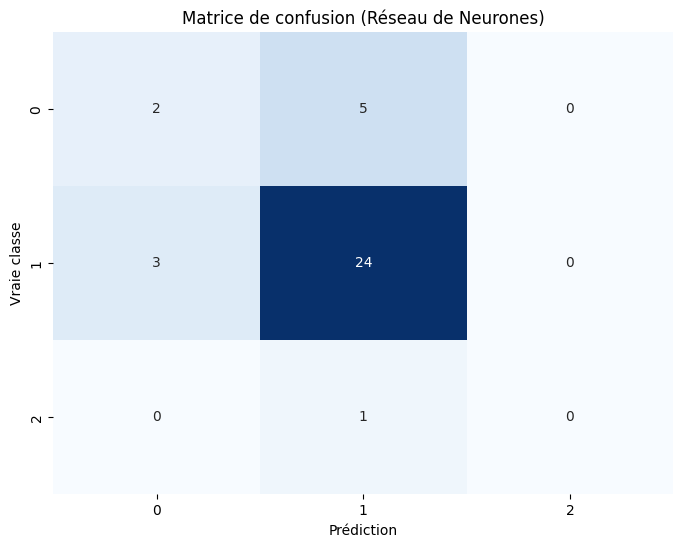

In [7]:
# 2. Matrice de confusion
cm = confusion_matrix(y_test_balanced, y_pred_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Matrice de confusion (Réseau de Neurones)')
plt.xlabel('Prédiction')
plt.ylabel('Vraie classe')
plt.show()

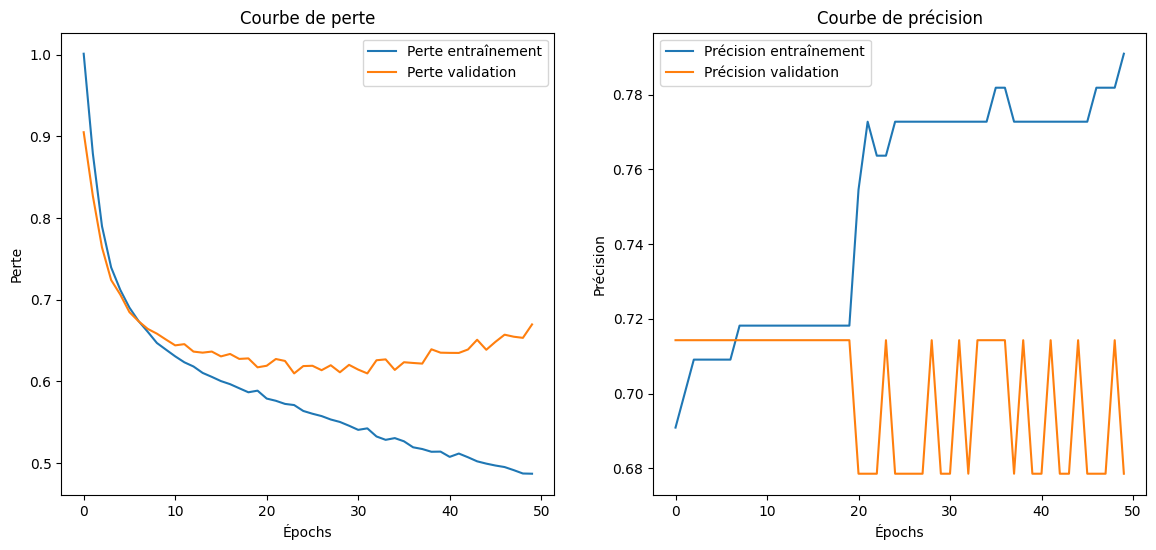

In [8]:
# 3. Courbe de perte et précision du modèle pendant l'entraînement
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Courbe de perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title('Courbe de précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.show()